In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange
from PIL import Image
from torchvision.transforms import ToTensor, Normalize
from time import time
import cv2
from tqdm.auto import tqdm

from implicit_kan.ChebyKANLayer import ChebyKANLayer
from implicit_kan.KANLayer import FastKANLayer, KANLinear
from implicit_kan.utils import get_grid, set_random_seed
from implicit_kan.modules import GaussianFourierFeatureTransform

h = 256
w = 256

num_steps = 3000

set_random_seed(1)

device = 'cuda'

/home/ubuntu/.cache/pypoetry/virtualenvs/implicit-kan-4tWFSK9Y-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img = ToTensor()(Image.open('./inputs/eye.jpeg').resize((h, w)))[None].to(device) * 2 - 1.

In [3]:
img.shape

torch.Size([1, 3, 256, 256])

In [4]:
grid = get_grid(img.shape[2], img.shape[3], b=1).to(device)

In [5]:
class ImplicitKAN(nn.Module):
    def __init__(self, pos_enc='gff'):
        super(ImplicitKAN, self).__init__()
        self.pos_enc = pos_enc
        assert pos_enc in ['gff', 'kan']
        if pos_enc == 'gff':
            self.pe = GaussianFourierFeatureTransform(mapping_dim=128)
        elif pos_enc == 'kan':
            self.pe =  FastKANLayer(2, 128)
        self.kan1 = FastKANLayer(256, 32)
        self.kan2 = FastKANLayer(32, 16)
        self.kan3 = FastKANLayer(16, 3)

    def forward(self, x):
        if self.pos_enc == 'kan':
            x = rearrange(x, "b c h w -> (b h w) c")  # Flatten the images
            x = self.pe(x)
        elif self.pos_enc == 'gff':
            x = self.pe(x)
            x = rearrange(x, "b c h w -> (b h w) c")  # Flatten the images
        x = self.kan1(x)
        x = self.kan2(x)
        x = self.kan3(x)
        return x.reshape(1, 3, h, w)

In [6]:
class ImplicitEKAN(nn.Module):
    def __init__(self, pos_enc='gff', grid_size=5):
        super(ImplicitEKAN, self).__init__()
        self.pos_enc = pos_enc
        assert pos_enc in ['gff', 'kan']
        if pos_enc == 'gff':
            self.pe = GaussianFourierFeatureTransform(mapping_dim=128)
        elif pos_enc == 'kan':
            self.pe =  KANLinear(2, 128, grid_size=grid_size)
        self.kan1 = KANLinear(256, 32, grid_size=grid_size)
        self.kan2 = KANLinear(32, 16, grid_size=grid_size)
        self.kan3 = KANLinear(16, 3, grid_size=grid_size)

    def forward(self, x):
        if self.pos_enc == 'kan':
            x = rearrange(x, "b c h w -> (b h w) c")  # Flatten the images
            x = self.pe(x)
        elif self.pos_enc == 'gff':
            x = self.pe(x)
            x = rearrange(x, "b c h w -> (b h w) c")  # Flatten the images
        x = self.kan1(x)
        x = self.kan2(x)
        x = self.kan3(x)
        return x.reshape(1, 3, h, w)
    
    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in [self.kan1, self.kan2, self.kan3]
        )

In [7]:
class ImplicitMLP(nn.Module):
    def __init__(self):
        super(ImplicitMLP, self).__init__()
        self.gff = GaussianFourierFeatureTransform(mapping_dim=128)
        self.linear1 = nn.Linear(2 * 128, 256)
        self.ln1 = nn.LayerNorm(256) # To avoid gradient vanishing caused by tanh
        self.linear2 = nn.Linear(256, 128)
        self.ln2 = nn.LayerNorm(128)
        self.linear3 = nn.Linear(128, 32)
        self.ln3 = nn.LayerNorm(32)
        self.linear4 = nn.Linear(32, 16)
        self.ln4 = nn.LayerNorm(16)
        self.linear5 = nn.Linear(16, 3)
    
    def forward(self, x):
        x = self.gff(x)
        x = rearrange(x, "b c h w -> (b h w) c")  # Flatten the images
        x = self.linear1(x)
        x = F.tanh(x)
        x = self.ln1(x)
        x = self.linear2(x)
        x = F.tanh(x)
        x = self.ln2(x)
        x = self.linear3(x)
        x = F.tanh(x)
        x = self.ln3(x)
        x = self.linear4(x)
        x = F.tanh(x)
        x = self.ln4(x)
        x = self.linear5(x)
        return x.reshape(1, 3, h, w)


In [8]:
kan_model = ImplicitEKAN(pos_enc='gff').to(device)
total_params = sum(p.numel() for p in kan_model.parameters() if p.requires_grad)
print(f"Total trainable parameters in efficient kan with gff: {total_params}")

kan_model_6 = ImplicitEKAN(pos_enc='gff', grid_size=6).to(device)
total_params = sum(p.numel() for p in kan_model_6.parameters() if p.requires_grad)
print(f"Total trainable parameters in efficient kan with gff grid 6: {total_params}")

kan_model_7 = ImplicitEKAN(pos_enc='gff', grid_size=7).to(device)
total_params = sum(p.numel() for p in kan_model_7.parameters() if p.requires_grad)
print(f"Total trainable parameters in efficient kan with gff grid 7: {total_params}")

kan_model_7_reg = ImplicitEKAN(pos_enc='gff', grid_size=7).to(device)
total_params = sum(p.numel() for p in kan_model_7_reg.parameters() if p.requires_grad)
print(f"Total trainable parameters in efficient kan with gff grid 7 with reg: {total_params}")

mlp = ImplicitMLP().to(device)
total_params_mlp = sum(p.numel() for p in mlp.parameters() if p.requires_grad)
print(f"Total trainable parameters in MLP with gff: {total_params_mlp}")

optim_kan = optim.AdamW(kan_model.parameters(), lr=1e-3, weight_decay=1e-4)
optim_kan_6 = optim.AdamW(kan_model_6.parameters(), lr=1e-3, weight_decay=1e-4)
optim_kan_7 = optim.AdamW(kan_model_7.parameters(), lr=1e-3, weight_decay=1e-4)
optim_kan_7_reg = optim.AdamW(kan_model_7_reg.parameters(), lr=1e-3, weight_decay=1e-4)
optim_mlp = optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=1e-4)

Total trainable parameters in efficient kan with gff: 87520
Total trainable parameters in efficient kan with gff grid 6: 96272
Total trainable parameters in efficient kan with gff grid 7: 105024
Total trainable parameters in efficient kan with gff grid 7 with reg: 105024
Total trainable parameters in MLP with gff: 104259


In [9]:
kan_loss = []
ekan_gff_imgs = []
start = time()
for step_idx in tqdm(range(num_steps)):
    optim_kan.zero_grad()
    out = kan_model(grid)
    loss = ((F.tanh(out) - img) ** 2).mean()
    loss.backward()
    optim_kan.step()
    kan_loss.append(((F.tanh(out) - img) ** 2).mean())
    ekan_gff_imgs.append(out)
kan_loss = [l.item() for l in kan_loss]
ekan_gff_imgs = [im.cpu().data.numpy() for im in ekan_gff_imgs]
print(f"trained in {time() - start} to {kan_loss[-1]}")

100%|██████████| 3000/3000 [03:42<00:00, 13.48it/s]


trained in 223.89411520957947 to 0.005482254084199667


In [10]:
kan_loss_reg = []
ekan_gff_imgs_reg = []
start = time()
for step_idx in tqdm(range(num_steps)):
    optim_kan_6.zero_grad()
    out = kan_model_6(grid)
    loss = ((F.tanh(out) - img) ** 2).mean()
    loss.backward()
    optim_kan_6.step()
    kan_loss_reg.append(((F.tanh(out) - img) ** 2).mean())
    ekan_gff_imgs_reg.append(out)
kan_loss_reg = [l.item() for l in kan_loss_reg]
ekan_gff_imgs_reg = [im.cpu().data.numpy() for im in ekan_gff_imgs_reg]
print(f"trained in {time() - start} to {kan_loss_reg[-1]}")

100%|██████████| 3000/3000 [04:05<00:00, 12.24it/s]


trained in 246.42459726333618 to 0.004047679714858532


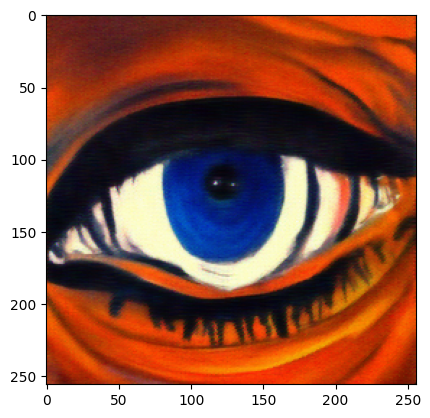

In [11]:
plt.imshow((F.tanh(out).cpu()[0].permute(1, 2, 0).data.numpy() + 1.) / 2.)

In [12]:
kan_gff_imgs = []
kan_gff_loss = []
start = time()
for step_idx in tqdm(range(num_steps)):
    optim_kan_7.zero_grad()
    out = kan_model_7(grid)
    loss = ((F.tanh(out) - img) ** 2).mean()
    loss.backward()
    optim_kan_7.step()
    kan_gff_loss.append(loss)
    kan_gff_imgs.append(out)

kan_gff_loss = [l.item() for l in kan_gff_loss]
kan_gff_imgs = [im.cpu().data.numpy() for im in kan_gff_imgs]

print(f"trained in {time() - start} to {loss.item()}")

100%|██████████| 3000/3000 [04:27<00:00, 11.23it/s]


trained in 268.6136326789856 to 0.003502101404592395


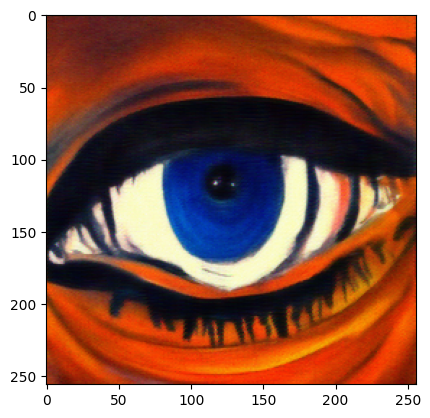

In [13]:
plt.imshow((F.tanh(out).cpu()[0].permute(1, 2, 0).data.numpy() + 1.) / 2.)

In [14]:
kan_7_reg_imgs = []
kan_7_reg_loss = []
start = time()
for step_idx in tqdm(range(num_steps)):
    optim_kan_7_reg.zero_grad()
    out = kan_model_7_reg(grid)
    loss = ((F.tanh(out) - img) ** 2).mean() + kan_model_7_reg.regularization_loss()
    loss.backward()
    optim_kan_7_reg.step()
    kan_7_reg_loss.append(((F.tanh(out) - img) ** 2).mean())
    kan_7_reg_imgs.append(out)

kan_7_reg_loss = [l.item() for l in kan_7_reg_loss]
kan_7_reg_imgs = [im.cpu().data.numpy() for im in kan_7_reg_imgs]

print(f"trained in {time() - start} to {loss.item()}")

100%|██████████| 3000/3000 [04:27<00:00, 11.20it/s]


trained in 269.2845103740692 to 8.991145133972168


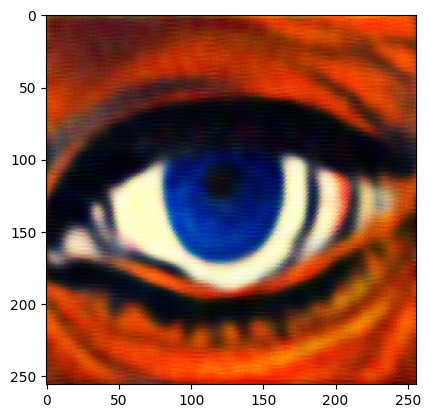

In [15]:
plt.imshow((F.tanh(out).cpu()[0].permute(1, 2, 0).data.numpy() + 1.) / 2.)

In [16]:
mlp_imgs = []
mlp_loss = []
start = time()
for step_idx in tqdm(range(num_steps)):
    mlp.zero_grad()
    out = mlp(grid)
    loss = ((F.tanh(out) - img) ** 2).mean()
    loss.backward()
    optim_mlp.step()
    mlp_loss.append(loss)
    mlp_imgs.append(out)

mlp_loss = [l.item() for l in mlp_loss]
mlp_imgs = [im.cpu().data.numpy() for im in mlp_imgs]

print(f"trained in {time() - start} to {loss.item()}")

100%|██████████| 3000/3000 [00:21<00:00, 138.39it/s]


trained in 22.860581874847412 to 0.0034853797405958176


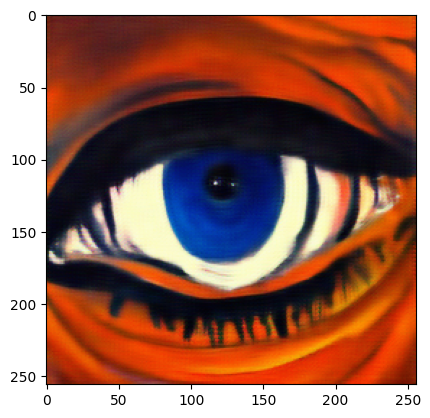

In [17]:
plt.imshow((F.tanh(out).cpu()[0].permute(1, 2, 0).data.numpy() + 1.) / 2.)

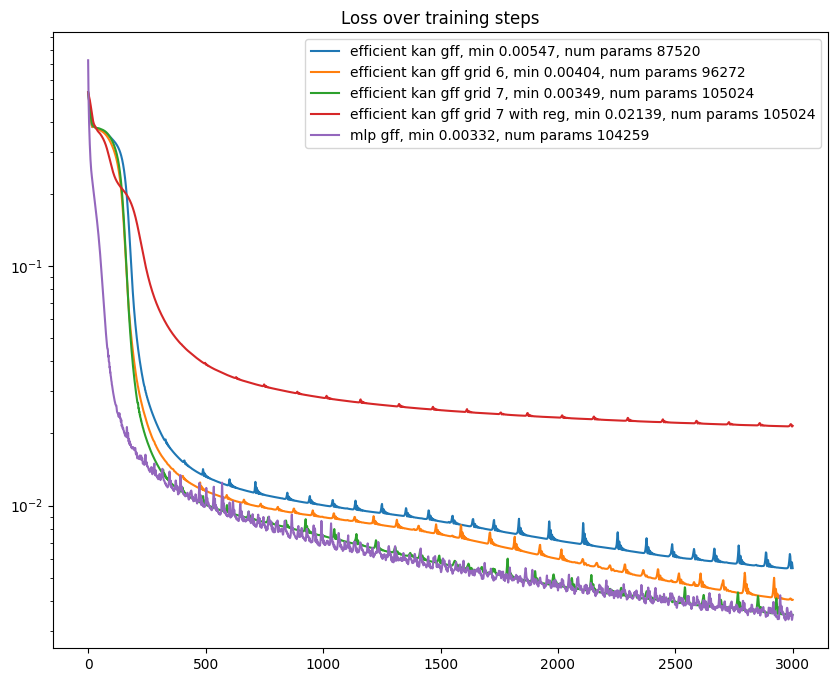

In [23]:
plt.plot(kan_loss, label=f'efficient kan gff, min {min(kan_loss):.5f}, num params {sum(p.numel() for p in kan_model.parameters() if p.requires_grad)}')

plt.plot(kan_loss_reg, label=f'efficient kan gff grid 6, min {min(kan_loss_reg):.5f}, num params {sum(p.numel() for p in kan_model_6.parameters() if p.requires_grad)}')

plt.plot(kan_gff_loss, label=f'efficient kan gff grid 7, min {min(kan_gff_loss):.5f}, num params {sum(p.numel() for p in kan_model_7.parameters() if p.requires_grad)}')

plt.plot(kan_7_reg_loss, label=f'efficient kan gff grid 7 with reg, min {min(kan_7_reg_loss):.5f}, num params {sum(p.numel() for p in kan_model_7_reg.parameters() if p.requires_grad)}')

plt.plot(mlp_loss, label=f'mlp gff, min {min(mlp_loss):.5f}, num params {sum(p.numel() for p in mlp.parameters() if p.requires_grad)}')

plt.legend()
plt.title("Loss over training steps")
plt.semilogy()
plt.rcParams["figure.figsize"] = (10, 13)

In [24]:
out = cv2.VideoWriter('converge.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 40, (w * 3, h))
for i in list(range(num_steps))[::4]:
    frame = (np.tanh(rearrange(np.concatenate([ekan_gff_imgs[i][0], kan_gff_imgs[i][0], mlp_imgs[i][0]], axis=2), "c h w -> h w c")) + 1) / 2. * 255
    out.write(frame.astype(np.uint8)[:, :, ::-1])
out.release()